In [38]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
from torch.nn import Linear, Sequential, ReLU, L1Loss, LSTM, BatchNorm1d
from torch.optim import Adam, lr_scheduler
import numpy as np

from BaseNetwork import BaseNetwork

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
prev_timesteps = 6
prediction_steps = 6
batch_size = 25

train = MoviaBusDataset('../data/train', 
                        interpolation=True, 
                        prev_timesteps=prev_timesteps, 
                        max_future_time_steps=prediction_steps,
                       agg_time=10)

test = MoviaBusDataset('../data/test', 
                       interpolation=True, 
                       prev_timesteps=prev_timesteps, 
                       max_future_time_steps=prediction_steps,
                      agg_time=10)

In [19]:
train.normalize(individual_roads=True)
test.normalize(train.mean, train.std)

In [47]:
num_timesteps = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[1]

class RNN(BaseNetwork):
    def __init__(self, num_layers=1, hidden=100):
        super(RNN, self).__init__()
        
        self.num_layers = num_layers
        
        self.lstm = LSTM(num_roads,num_roads, batch_first=True, num_layers=num_layers, dropout=0.4)
        self.l1 = Linear(in_features=num_roads, out_features=num_roads)
        self.activation = ReLU()
        self.BN = BatchNorm1d(num_roads)
        
    def forward(self,x):
        #x : [batch_size, timesteps, wayids]
        
        n_batch = x.size()[0]
        hidden = (torch.randn(self.num_layers, n_batch, num_roads),#.cuda(),
                  torch.randn(self.num_layers, n_batch, num_roads))#.cuda())
        
        #Run model on previous timesteps
        for t_i in range(prev_timesteps):
            out, hidden = self.lstm(x[:,t_i,:].view(-1,1,num_roads),hidden)
            
            #out = self.l1(out)
        
        
           
        predictions = []
        #Use the model to predict several timesteps into the future
        for i in range(prediction_steps):
            
            out, hidden = self.lstm(out.view(-1,1,num_roads),hidden)
            #out = self.l1(out)
            prediction = out[:,0,:self.num_roads]
        
            predictions.append(prediction)
      
        return torch.stack(predictions,1)

net = RNN(num_layers=2)

optimizer_fun = lambda param : Adam(param, lr=1e-3, weight_decay=0)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
criterion = L1Loss()

In [48]:
net.train_network(train, test,batch_size=batch_size, 
                  num_epochs=30,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  #shuffle=True,
                  criterion=criterion)

epoch =  0  train loss = 1.414   test loss = 1.340   output_std = 0.350
epoch =  2  train loss = 1.375   test loss = 1.344   output_std = 0.420
epoch =  4  train loss = 1.371   test loss = 1.335   output_std = 0.324
epoch =  6  train loss = 1.366   test loss = 1.323   output_std = 0.337
epoch =  8  train loss = 1.357   test loss = 1.331   output_std = 0.392
epoch = 10  train loss = 1.350   test loss = 1.330   output_std = 0.336
epoch = 12  train loss = 1.339   test loss = 1.331   output_std = 0.354
epoch = 14  train loss = 1.329   test loss = 1.339   output_std = 0.454
epoch = 16  train loss = 1.322   test loss = 1.341   output_std = 0.420
epoch = 18  train loss = 1.314   test loss = 1.342   output_std = 0.446
epoch = 20  train loss = 1.305   test loss = 1.344   output_std = 0.494
epoch = 22  train loss = 1.298   test loss = 1.352   output_std = 0.506
epoch = 24  train loss = 1.289   test loss = 1.348   output_std = 0.506
epoch = 26  train loss = 1.283   test loss = 1.359   output_std 

In [41]:
net.train_network(train, test,batch_size=batch_size, 
                  num_epochs=30,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  #shuffle=True,
                  criterion=criterion)

epoch =  0  train loss = 1.484   test loss = 1.436   output_std = 0.490
epoch =  2  train loss = 1.474   test loss = 1.422   output_std = 0.423
epoch =  4  train loss = 1.471   test loss = 1.425   output_std = 0.456
epoch =  6  train loss = 1.469   test loss = 1.419   output_std = 0.425
epoch =  8  train loss = 1.463   test loss = 1.422   output_std = 0.532
epoch = 10  train loss = 1.454   test loss = 1.423   output_std = 0.488
epoch = 12  train loss = 1.447   test loss = 1.435   output_std = 0.559
epoch = 14  train loss = 1.439   test loss = 1.441   output_std = 0.555
epoch = 16  train loss = 1.424   test loss = 1.443   output_std = 0.613
epoch = 18  train loss = 1.408   test loss = 1.445   output_std = 0.581
epoch = 20  train loss = 1.395   test loss = 1.446   output_std = 0.638
epoch = 22  train loss = 1.375   test loss = 1.449   output_std = 0.623
epoch = 24  train loss = 1.359   test loss = 1.471   output_std = 0.660
epoch = 26  train loss = 1.342   test loss = 1.475   output_std 

In [34]:
net.train_network(train, test,batch_size=batch_size, 
                  num_epochs=30,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  #shuffle=True,
                  criterion=criterion)

epoch =  0  train loss = 0.748   test loss = 0.707   output_std = 0.133
epoch =  2  train loss = 0.739   test loss = 0.706   output_std = 0.166
epoch =  4  train loss = 0.733   test loss = 0.708   output_std = 0.181
epoch =  6  train loss = 0.723   test loss = 0.716   output_std = 0.237
epoch =  8  train loss = 0.713   test loss = 0.720   output_std = 0.253
epoch = 10  train loss = 0.701   test loss = 0.723   output_std = 0.271
epoch = 12  train loss = 0.690   test loss = 0.729   output_std = 0.290
epoch = 14  train loss = 0.681   test loss = 0.744   output_std = 0.338
epoch = 16  train loss = 0.673   test loss = 0.748   output_std = 0.325
epoch = 18  train loss = 0.664   test loss = 0.752   output_std = 0.358
epoch = 20  train loss = 0.656   test loss = 0.747   output_std = 0.334
epoch = 22  train loss = 0.651   test loss = 0.760   output_std = 0.382
epoch = 24  train loss = 0.644   test loss = 0.760   output_std = 0.380
epoch = 26  train loss = 0.640   test loss = 0.764   output_std 

KeyboardInterrupt: 

In [49]:
scores=[net.get_MAE_score(timestep=i) for i in range(1,prediction_steps+1)]
print(scores)
print(sum(scores)/len(scores))

[1.3332475423812866, 1.3459583520889282, 1.3597352504730225, 1.3676552772521973, 1.3764585256576538, 1.3833813667297363]
1.3610727190971375


<IPython.core.display.Javascript object>


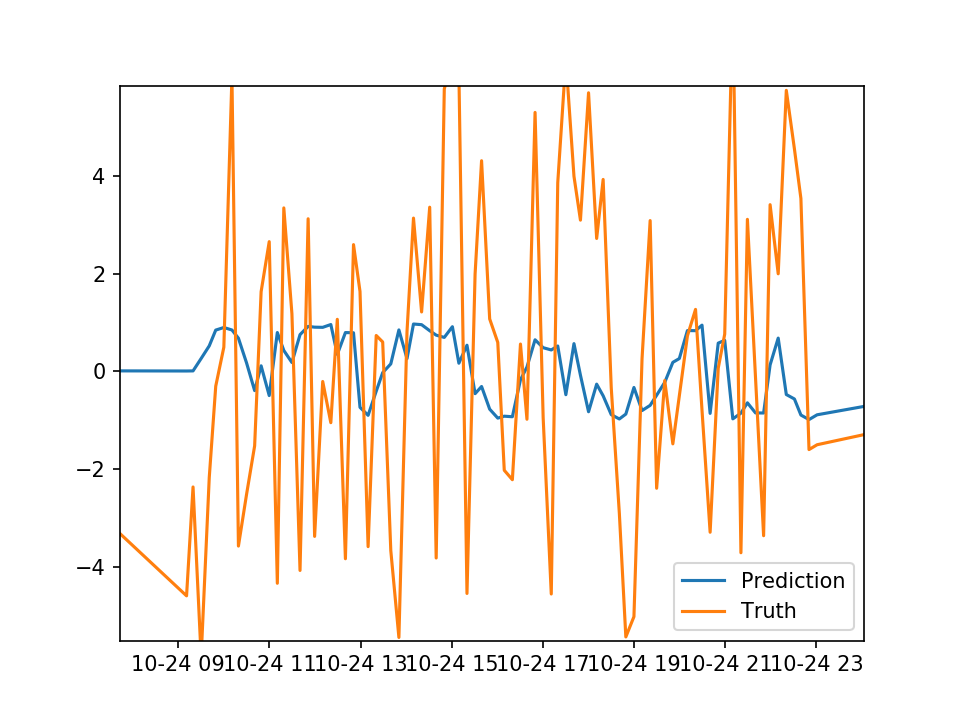

In [52]:
%matplotlib notebook

net.visualize_road(timesteps=1, road=83)

* 2 lstms
* indivual_road=True
* prev=6
* batch=25
* MAE=
[1.5938279628753662, 1.597127079963684, 1.6026233434677124, 1.6077381372451782, 1.6123509407043457, 1.6204285621643066]
1.6056826710700989


* 2 lstms
* indivual_road=False
* prev=6
* batch=100
* dropout = 0.3
* MAE=
[1.7410115003585815, 1.7417702674865723, 1.7435261011123657, 1.7450439929962158, 1.7469359636306763, 1.750575065612793]
1.7448104818662007


* 2 lstms
* Individual_road = True
* shuffle = False
* dropout = 0.3
* batch = 100
* lr = 1e-3
* MAE =
[1.617242693901062, 1.6234548091888428, 1.6301486492156982, 1.6363787651062012, 1.6430387496948242, 1.6502679586410522]
1.6334219376246135


* 2 lstms
* Individual_road = True
* shuffle = False
* dropout = 0
* batch = 100
* lr = 1e-3
* MAE =
[1.6509093046188354, 1.6624853610992432, 1.6709977388381958, 1.6783303022384644, 1.6858181953430176, 1.690630555152893]
1.673195242881775


* 2 lstms
* indivual_road=True
* prev=6
* batch=25
* epochs = 10
* MAE =
[1.6019037961959839, 1.6057021617889404, 1.610262393951416, 1.6147956848144531, 1.6188633441925049, 1.6230062246322632]
1.612422267595927


* 2 lstms
* indivual_road=True
* prev=6
* batch=25
* epochs = 3
* shuffle=True
* MAE = 
[1.6663920879364014, 1.6784924268722534, 1.6891628503799438, 1.6988554000854492, 1.7062901258468628, 1.713460087776184]
1.6921088298161824

<IPython.core.display.Javascript object>


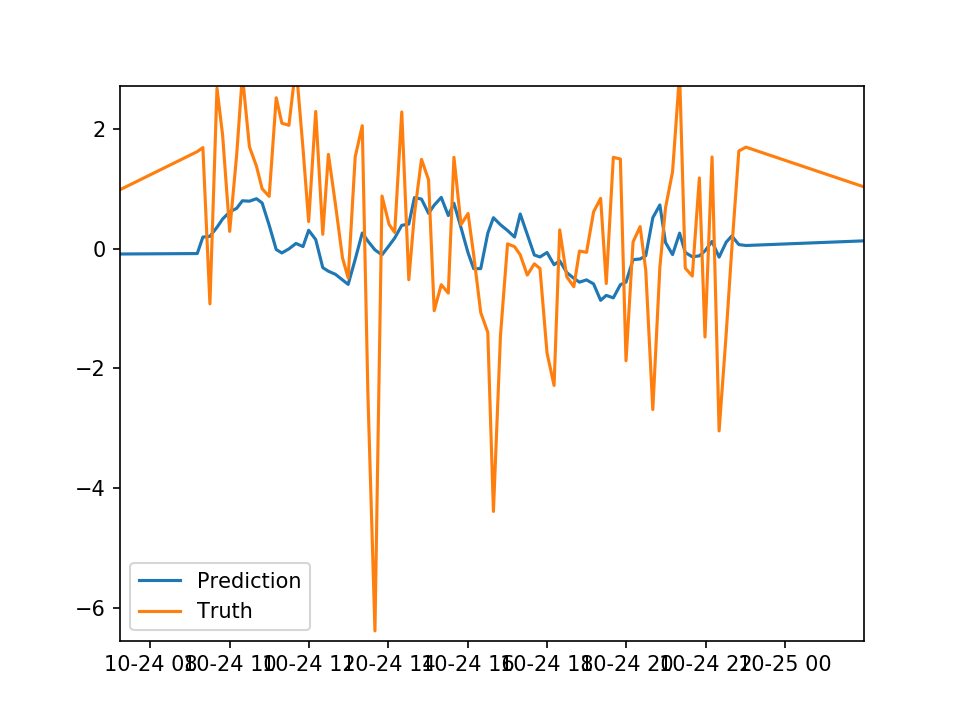

In [51]:
%matplotlib notebook

net.visualize_road(timesteps=1, road=21)

* 2 lstms
* no normalization
* prev=6
* batch=25
* epochs = 30
* shuffle= false
* l1
* agg = 5min
* dropout = 0.4
* MAE = [1.4442533254623413, 1.4579745531082153, 1.466296911239624, 1.4781726598739624, 1.4906038045883179, 1.493666410446167]
1.4718279441197712

* 2 lstms
* no normalization
* prev=6
* batch=25
* epochs = 30
* shuffle= false
* no l1
* agg = 5min
* dropout = 0.4
* MAE = [1.4392585754394531, 1.4480527639389038, 1.453688144683838, 1.4576399326324463, 1.4612764120101929, 1.46430242061615]
1.4540363748868306

* 2 lstms
* no normalization
* prev=6
* batch=25
* epochs = 30
* shuffle= false
* no l1
* agg = 10min
* dropout = 0.4
* MAE = [1.3332475423812866, 1.3459583520889282, 1.3597352504730225, 1.3676552772521973, 1.3764585256576538, 1.3833813667297363]
1.3610727190971375